In [2]:
import project_path

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sqlite3 as sl
from tqdm import tqdm
from typing import List, Any, Tuple, Dict

from lib.utils import iterate_over
from lib.utils import load_config_and_check
from lib.inspector import Inspector

%load_ext autoreload
%autoreload 2

# Parameters

In [3]:
EXP_FOLDER = "qmt_v12" 
SQL_PATH = os.path.join("..", "data", EXP_FOLDER, "qfl.db")
LOG_PATH = os.path.join("..", "data", EXP_FOLDER, "log_fuzzy.txt")
SQL_CONNECTION = sl.connect(SQL_PATH)


In [4]:
OUT_FOLDER = "../data/paper_images"
PVAL_COL = "divergence.ks.p-value" 
ALPHA_LEVEL = 0.05

# Load Data

In [5]:
df_crash = pd.read_sql("""SELECT * from CRASHDATA""", SQL_CONNECTION)
df_data = pd.read_sql("""SELECT * from QFLDATA""", SQL_CONNECTION)
#LOG_CONTENT = open(LOG_PATH, 'r').read()
#LOG_LINES = LOG_CONTENT.split("\n")
print(f"Total (potentially divergent) comparisons: {len(df_data)}")
print(f"Total crash in programs: {len(df_crash)}")
print(f"\tcrashing source: {len(df_crash[~df_crash['exceptions.source'].isna()])}")
print(f"\tcrashing follow-up: {len(df_crash[~df_crash['exceptions.followup'].isna()])}")

Total (potentially divergent) comparisons: 16800
Total crash in programs: 6535
	crashing source: 0
	crashing follow-up: 6535


In [6]:
df_generated_programs = pd.concat(
    [
        df_data.assign(generated_a_crash=False),
        df_crash.assign(generated_a_crash=True)
    ],
    axis=0
)
df_generated_programs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23335 entries, 0 to 6534
Data columns (total 43 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   index                                       23335 non-null  int64  
 1   program_id                                  23335 non-null  object 
 2   time_exec                                   23335 non-null  float64
 3   abs_start_time                              23335 non-null  int64  
 4   source.program_id                           23335 non-null  object 
 5   source.selected_gate_set                    23335 non-null  object 
 6   source.selected_optimization                23335 non-null  object 
 7   source.shots                                23335 non-null  int64  
 8   source.n_qubits                             23335 non-null  int64  
 9   source.n_ops                                23335 non-null  int64  
 10  source.opt_

# Preface

In [52]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.tools.visualization import plot_histogram

# Create circuit
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get counts
result = simulator.run(circ).result()
result.get_counts(circ)

{'11': 511, '00': 513}

/tmp/ipykernel_23792/708910746.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


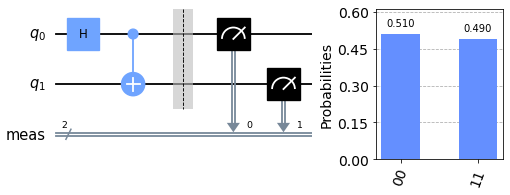

In [76]:
fig = plt.figure(constrained_layout=True, figsize=(7, 2.6))
gs = fig.add_gridspec(1, 24)
ax_circuit = fig.add_subplot(gs[:17])
ax_histogram = fig.add_subplot(gs[17:])

circ.draw(
    output='mpl', 
    justify=None,
    style={"margin": [1.23, 0, 0, 0]},
    ax=ax_circuit
)
#ax_circuit.set_title("Gate Model")


plot_histogram(
    counts, 
    #title='Output Distribution',
    ax=ax_histogram    
)

plt.tight_layout()

fig.savefig(os.path.join(OUT_FOLDER, "example_circuit.pdf"))

# RQ 1: how many warnings in a fixed budget time (2 days)?
2 days = as used by QDiff 

In [75]:
from lib.inspector import get_alarms_with_method

def get_program_within_first_hours(df, n_hours: int, col_time: str = "abs_start_time"):
    """Get the programs generated in the first n hours."""
    df = df.sort_values(by=col_time)
    approach_start_time = int(df[col_time].min())
    df["time_since_start"] = df[col_time].apply(
        lambda c_program_start_time: c_program_start_time - approach_start_time
    )
    return df[df["time_since_start"] < 3600 * n_hours]

N_HOURS = 48

df_first_2_days = get_program_within_first_hours(
    df=df_generated_programs,
    n_hours=N_HOURS
)
df_first_2_days_crash = df_first_2_days[df_first_2_days["generated_a_crash"]]
df_first_2_days_complete = df_first_2_days[~df_first_2_days["generated_a_crash"]]

print(f"In the first {N_HOURS} hours we tested {len(df_first_2_days)} program pairs")

n_tot_pairs = len(df_first_2_days)
n_crash = len(df_first_2_days_crash)
n_complete_execution = len(df_first_2_days_complete)
assert n_crash + n_complete_execution == n_tot_pairs

perc_crash = (n_crash / n_tot_pairs) * 100
perc_complete_execution = (n_complete_execution / n_tot_pairs) * 100

print(f"{n_crash} ({perc_crash:.2f} %) crashes")
print(f"{n_complete_execution} ({perc_complete_execution:.2f} %) complete executions")


n_crash_source = len(df_first_2_days_crash[~df_first_2_days_crash['exceptions.source'].isna()])
n_crash_followup = len(df_first_2_days_crash[~df_first_2_days_crash['exceptions.followup'].isna()]) 
perc_crash_source = (n_crash_source / n_tot_pairs) * 100
perc_crash_followup = (n_crash_followup / n_tot_pairs) * 100

PVAL_COL = "divergence.ks.p-value"
ALPHA_LEVEL = 0.05

program_ids_bonferroni = get_alarms_with_method(
    df=df_first_2_days_complete, 
    pval_col=PVAL_COL,
    alpha_level=ALPHA_LEVEL,
    method='bonferroni')
n_divergence = len(program_ids_bonferroni)
perc_divergence = (n_divergence / n_tot_pairs) * 100

print("% RQ1")
print("\\newcommand{\percCrashesBenchmark}{"+f"{perc_crash:.2f}"+"\%}")

print("""
\\begin{table}[t]
  \centering
  % """ + EXP_FOLDER + """
  \caption{Distribution of warnings over two days.}
  \\begin{tabular}{lrr}
  \\toprule
  & Number & Percentage \\\\
  \\midrule
  Total Program Pairs Tested& """ + f"{len(df_first_2_days)}"+ """& - \\\\
  Crash in Source Program & """ + f"{n_crash_source} & ({perc_crash_source:.2f} \\%)"+ """\\\\
  Crash in Follow-up Program & """ + f"{n_crash_followup} & ({perc_crash_followup:.2f} \\%)"+ """\\\\
  Successful Execution & """ + f"{n_complete_execution} & ({perc_complete_execution:.2f} \\%)"+ """\\\\
  (of which divergent) & """ + f"{n_divergence} & ({perc_divergence:.2f} \\%)"+ """\\\\
  \\bottomrule
  \end{tabular}
  \label{tab:warnings_distribution}
\end{table}
""")

In the first 48 hours we tested 9007 program pairs
2548 (28.29 %) crashes
6459 (71.71 %) complete executions
% RQ1
\newcommand{\percCrashesBenchmark}{28.29\%}

\begin{table}[t]
  \centering
  % qmt_v12
  \caption{Distribution of warnings over two days.}
  \begin{tabular}{lrr}
  \toprule
  & Number & Percentage \\
  \midrule
  Total Program Pairs Tested& 9007& - \\
  Crash in Source Program & 0 & (0.00 \%)\\
  Crash in Follow-up Program & 2548 & (28.29 \%)\\
  Successful Execution & 6459 & (71.71 \%)\\
  (of which divergent) & 0 & (0.00 \%)\\
  \bottomrule
  \end{tabular}
  \label{tab:warnings_distribution}
\end{table}



# RQ 2: which real bugs have been found in Qiskit via metamorphic testing?
See interesting cases folders + discussion section + qiskit issues (Notebook number 37)

In [117]:
# create latex table
PATH_DATASET = "../intersting_cases/curated_google_sheet/Qiskit_Bug_Dataset - main_dataset.csv"
df_bugs = pd.read_csv(PATH_DATASET)
df_bugs = df_bugs.sort_values(by=[
    "status"
], ascending=True)
df_bugs = df_bugs.reset_index(drop=True)
df_bugs = df_bugs.reset_index(drop=False)
df_bugs = df_bugs.fillna("-")
df_bugs.head()

,index,bug_id,experiment,program_id,date_found,date_reported,manifestation,hook_hint,crash_category,present_also_in_final_run,root_cause,API_usage,mr_used,bug_description,link_to_issue,developer_reaction,developer comment,component,known_before,status
0,0,01_6e8363,qmt_v01,6e8363d301e44b0c833f51d6918af826,9-feb-22,9-feb-22,crash,Instruction id not found in equivalence library,Instruction id not found,True,IDGate,correct,ChangeTargetBasis,Circuit with identity gate fails to transpile ...,https://github.com/Qiskit/qiskit-terra/issues/...,"comment ""bug due to legacy reason""; confirmed;...","""This is because id in Terra isn't actually an...",-,duplicate,confirmed
1,1,01_accidental,qmt_v01,-,8-feb-22,8-feb-22,timeout,-,-,False,inefficient translation basis,non-existent gate names,ChangeTargetBasis,"Compiler hangs (infinite loop), when transpile...",https://github.com/Qiskit/qiskit-terra/issues/...,comment; confirmed; similar issue; fix is read...,"""This is similar to #5539, perhaps a slightly ...",-,duplicate (different manifestation),confirmed
2,2,06_59a0eb,qmt_v06,59a0eb956a0d4e6b8720f272136f2799,21-feb-22,21-feb-22,crash,qargs not in this circuit,qargs not in this circuit,False,ApplyLayout pass,borderline,"ChangeOptLevel, ChangeCouplingMap",Transpilation (level 3 + custom Coupling Map) ...,https://github.com/Qiskit/qiskit-terra/issues/...,comment,"""It is a slightly strange and non-ideal behavi...",-,new,confirmed
3,3,06_948f90,qmt_v06,948f90de9947418289b220bd2e61caa3,23-feb-22,23-feb-22,crash,too many subscripts in einsum,too many subscripts in einsum (numpy),True,Numpy limits,correct,"ChangeOptLevel, InjectNullEffect",Transpilation (Opt. Level 2) fails with regist...,https://github.com/Qiskit/qiskit-terra/issues/...,comment,"""it shakes out that once your operators have 1...",-,new,confirmed
4,4,09_f8a306,qmt_v09,f8a306d8953f4e46a2b8ecec434f9cc0,8-mar-22,-,crash,"Mismatch between run_config.parameter_binds, u...",Mismatch between parameter_binds,True,CUGate,correct,InjectParameters,CUGate's params getter does not comply with ci...,https://github.com/Qiskit/qiskit-terra/issues/...,duplicated; confirmed by developer,-,-,duplicate,confirmed


In [118]:
df_bugs["Dev discovery"] = df_bugs.apply(
    lambda row: "✓" if not row["present_also_in_final_run"] else "",
    axis=1
)

In [119]:
ANONYMOUS = False
KEEP_ONLY_CONFIRMED = True 

col_renaming = {
    "index": "ID",
    "mr_used": "Metamorphic Transf.",
    "link_to_issue": "Report",
    "status": "Status",
    #"API_usage": "API usage",
    "manifestation": "How",
    "crash_category": "Crash Msg",
    "known_before": "Novelty",
    #"bug_description": "Description",
    #"root_cause": "Root Cause",
}

if ANONYMOUS:
    df_bugs["link_to_issue"] = "#XXXX"
else:
    df_bugs["link_to_issue"] = df_bugs["link_to_issue"].apply(
        lambda e: e.replace("https://github.com/Qiskit/qiskit-terra/issues/", "#")
    )

df_bugs["known_before"] = df_bugs["known_before"].apply(
    lambda e: str(e).replace("duplicate (different manifestation)", "duplicate*")
)

In [120]:
relevant_columns = col_renaming.keys()
df_table = df_bugs[relevant_columns].rename(columns=col_renaming)
df_table.head()

print(df_table.to_latex(
    column_format='lp{3cm}lllp{6.5cm}l',
    index=False))

\begin{tabular}{lp{3cm}lllp{6.5cm}l}
\toprule
 ID &                  Metamorphic Transf. & Report &         Status &        How &                                         Crash Msg &    Novelty \\
\midrule
  0 &                    ChangeTargetBasis &  \#7641 &      confirmed &      crash &                          Instruction id not found &  duplicate \\
  1 &                    ChangeTargetBasis &  \#7636 &      confirmed &    timeout &                                                 - & duplicate* \\
  2 &    ChangeOptLevel, ChangeCouplingMap &  \#7694 &      confirmed &      crash &                         qargs not in this circuit &        new \\
  3 &     ChangeOptLevel, InjectNullEffect &  \#7700 &      confirmed &      crash &             too many subscripts in einsum (numpy) &        new \\
  4 &                     InjectParameters &  \#7326 &      confirmed &      crash &                  Mismatch between parameter\_binds &  duplicate \\
  5 &                     InjectParamet

## How crashes lead to the different bugs?

In [121]:
from copy import deepcopy

def normalize_names(df: pd.DataFrame, col: str, mapping:List[Tuple[str, str]]):
    """Replace the value of the given column according to the mapping.
    
    Each cell that contains the first string, will be replaced completely 
    with the second string of the tuple."""
    df = deepcopy(df)
    for hook, replacement in mapping:
        if isinstance(hook, list):
            for sub_hook in hook:
                df.loc[df[col].str.contains(sub_hook), col] = replacement
        else:
            df.loc[df[col].str.contains(hook), col] = replacement
    return df

In [122]:
from collections import Counter

K = 10
print(f"TOP {K} CRASH MESSAGES (without normalization)")
c = Counter(df_crash["exceptions.followup"])
c.most_common(3)

TOP 10 CRASH MESSAGES (without normalization)


[('"Duplicate declaration for gate \'rzx\' at line 4, file .\\nPrevious occurrence at line 3, file "',
  3588),
 ('"Duplicate declaration for gate \'rzx\' at line 6, file .\\nPrevious occurrence at line 5, file "',
  645),
 ('"Cannot find gate definition for \'rzx\', line 3 file "', 126)]

Instruction id not found in equivalence library  >  Instruction id not found
qargs not in this circuit  >  qargs not in this circuit
too many subscripts in einsum  >  too many subscripts in einsum (numpy)
['Mismatch between run_config.parameter_binds', ' unbound parameters']  >  Mismatch between parameter_binds
Cannot bind parameters  >  Cannot bind parameters not present in the circuit
Duplicate declaration for gate 'rzx'  >  Duplicate declaration for gate 'rzx'
Gate or opaque call to 'subcircuit'  >  Gate or opaque call to 'subcircuit'
Cannot find gate definition for 'c3sx'  >  Cannot find gate definition for 'c3sx'
Unable to map source basis  >  Unable to map source basis
greater than maximum  >  Number of qubits larger than coupling_map
QREG size must be positive  >  QREG size must be positive
Cannot find gate definition for 'rzx'  >  Cannot find gate definition for 'rzx'
Duplicate declaration for gate 'ryy'  >  Duplicate declaration for gate 'ryy'


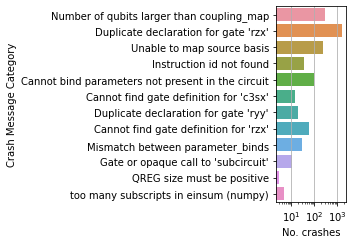

In [160]:
exception_attribution = [
    {
        "hint": "Mismatch between run_config.parameter_binds",
        "desc": "Mismatch between run_config.parameter_binds",
        "short": "CUGate",
        "mr": ["InjectParameters"],
        "status": "confirmed",
        "n_bugs": 1
    },
    {
        "hint": ["Cannot bind parameters", "unbound parameters"],
        "desc": "Cannot bind parameters",
        "short": "C3XGate,CU3Gate",
        "mr": ["InjectParameters"],
        "status": "confirmed",
        "n_bugs": 2
    },
    {
        "hint": "greater than maximum",
        "desc": "Number of qubits larger than coupling_map",
        "short": "Coupling+NewRegister",
        "mr": ["AddUnusedRegister"],
        "status": "false positive",
        "n_bugs": 0
    },
    {
        "hint": "Unable to map source basis",
        "desc": "Unable to map source basis",
        "short": "NoEquivalenceInLib",
        "mr": ["ChangeCouplingMap"],
        "status": "false positive",
        "n_bugs": 0
    },
    {
        "hint": "QREG size must be positive",
        "desc": "Add zero size register",
        "short": "NoEquivalenceInLib",
        "mr": ["AddUnusedRegister"],
        "status": "false positive",
        "n_bugs": 0
    },
    {
        "hint": "Instruction id not found",
        "desc": "Instruction id not found",
        "short": "IDGate",
        "mr": ["ChangeCouplingMap"],
        "status": "confirmed",
        "n_bugs": 1
    },
    {
        "hint": "Cannot find gate definition for 'c3sx'",
        "desc": "Cannot find gate definition for 'c3sx'",
        "short": "c3sx wrong def",
        "mr": ["ToQasmAndBack"],
        "status": "confirmed",
        "n_bugs": 1
    },
    {
        "hint": "Gate or opaque call to 'subcircuit'",
        "desc": "Gate or opaque call to 'subcircuit'",
        "short": "no classic reg in gate",
        "mr": ["ToQasmAndBack"],
        "status": "confirmed",
        "n_bugs": 1
    },
    {
        "hint": "Duplicate declaration for gate 'rzx'",
        "desc": "Duplicate declaration for gate 'rzx'",
        "short": "ECRGate",
        "mr": ["ToQasmAndBack"],
        "status": "confirmed",
        "n_bugs": 1
    },
    {
        "hint": "Duplicate declaration for gate 'ryy'",
        "desc": "Duplicate declaration for gate 'ryy'",
        "short": "RYYGate in Subcircuit",
        "mr": ["ToQasmAndBack", "InjectNullEffect"],
        "status": "confirmed",
        "n_bugs": 1
    },
    {
        "hint": "Cannot find gate definition for 'rzx'",
        "desc": "Cannot find gate definition for 'rzx'",
        "short": "ECRate in subcircuit + inverse",
        "mr": ["ToQasmAndBack", "InjectNullEffect"],
        "status": "confirmed",
        "n_bugs": 1
    },
    {
        "hint": "too many subscripts in einsum",
        "desc": "too many subscripts in einsum (Numpy)",
        "short": "Too big subcricuit",
        "mr": ["InjectNullEffect"],
        "status": "confirmed",
        "n_bugs": 1
    }
]

exception_mapping = [
    [e['hint'], e['desc']] for e in exception_attribution
]

exception_mapping = list(zip(df_bugs["hook_hint"], df_bugs["crash_category"]))
# remove spurious tuple ("-", "-") comuning from bugs detected via divergence
# in the dataset
exception_mapping = [
    e
    for e in exception_mapping
    if (e[0] != "-" and e[1] != "-")
]
# separate those with multiple hooks separated by the comma
# this happens because we might have multiple messages which maps back to the
# same crash category
exception_mapping = [
    (e[0].split(","), e[1]) if "," in e[0] else e 
    for e in exception_mapping
]

[print(e[0], " > ", e[1]) for e in exception_mapping]

df_crash_norm = normalize_names(
    df=df_first_2_days_crash, 
    col="exceptions.followup",
    mapping=exception_mapping
)

fig, ax = plt.subplots(figsize=(5, 3.5))

sns.countplot(
    data=df_crash_norm,
    y="exceptions.followup",
    ax=ax
)
ax.set_ylabel("Crash Message Category")
ax.set_xlabel("No. crashes")
ax.grid(axis='x')
ax.set_xscale('log')
#ax.set_xlim(0, 100)
#ax.set_title("Crash Messages (Normalized)")
plt.tight_layout()
fig.savefig(os.path.join(OUT_FOLDER, "RQ2_count_plot_crash_messages.pdf"))

# RQ 3: how do the different metamorphic relations contribute?

## Relationship between MR and unique crashes messages

In [153]:
relevant_columns = list(df_bugs.columns)
relevant_columns.remove("program_id")
df_crash_to_MR = pd.merge(
    left=df_crash_norm,
    right=df_bugs[relevant_columns],
    left_on="exceptions.followup",
    right_on="crash_category",
)
df_crash_to_MR = df_crash_to_MR.groupby(
    by=["crash_category", "mr_used", "status"]
)["program_id"].count().reset_index().rename(columns={
    "program_id": "count"
})
df_crash_to_MR.head(20)

,crash_category,mr_used,status,count
0,Cannot bind parameters not present in the circuit,InjectParameters,confirmed,101
1,Cannot find gate definition for 'c3sx',ToQasmAndBack,confirmed,15
2,Cannot find gate definition for 'rzx',ToQasmAndBack,-,60
3,Duplicate declaration for gate 'ryy',ToQasmAndBack,-,19
4,Duplicate declaration for gate 'rzx',ToQasmAndBack,confirmed,1719
5,Gate or opaque call to 'subcircuit',ToQasmAndBack,confirmed,11
6,Instruction id not found,ChangeTargetBasis,confirmed,37
7,Mismatch between parameter_binds,InjectParameters,confirmed,31
8,Number of qubits larger than coupling_map,"ChangeCouplingMap, AddUnusedRegister",false positive,297
9,QREG size must be positive,AddUnusedRegister,false positive,3


In [154]:
all_labels = list(set(
    df_crash_to_MR["mr_used"].tolist() + 
    df_crash_to_MR["crash_category"].tolist() +
    df_crash_to_MR["status"].tolist()
))

mapping_labels_to_node_ids = {
    e: i
    for i, e in enumerate(all_labels)
}

In [155]:
mapping_labels_to_node_ids

{'too many subscripts in einsum (numpy)': 0,
 'false positive': 1,
 'InjectParameters': 2,
 'AddUnusedRegister': 3,
 'ToQasmAndBack': 4,
 'confirmed': 5,
 'Mismatch between parameter_binds': 6,
 'ChangeOptLevel, InjectNullEffect': 7,
 'ChangeTargetBasis': 8,
 'Number of qubits larger than coupling_map': 9,
 "Duplicate declaration for gate 'ryy'": 10,
 'QREG size must be positive': 11,
 "Duplicate declaration for gate 'rzx'": 12,
 'ChangeCouplingMap, AddUnusedRegister': 13,
 '-': 14,
 'Instruction id not found': 15,
 'Cannot bind parameters not present in the circuit': 16,
 'Unable to map source basis': 17,
 "Gate or opaque call to 'subcircuit'": 18,
 "Cannot find gate definition for 'c3sx'": 19,
 "Cannot find gate definition for 'rzx'": 20}

In [159]:
import plotly.graph_objects as go

crash_msg_true_bugs = list(df_bugs[df_bugs["status"] == "confirmed"]["crash_category"])

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(color = "black", width = 0),
      label = list(mapping_labels_to_node_ids.keys()),
      color = ["orange" if node_name in crash_msg_true_bugs else 'gray'
               for node_name in mapping_labels_to_node_ids.keys()]
    ),
    link = dict(
      target = df_crash_to_MR["mr_used"].map(mapping_labels_to_node_ids),
      source = df_crash_to_MR["crash_category"].map(mapping_labels_to_node_ids), # indices correspond to labels, eg A1, A2, A1, B1, ...
      value = df_crash_to_MR["count"]
  ))])

fig.update_layout(
    autosize=False,
    width=520,
    height=400,
    margin=dict(l=20, r=20, t=20, b=20)
)

fig.show()
fig.write_image(os.path.join(OUT_FOLDER, "RQ3_sankey_crash_to_MR.pdf"))

## To crashes
How do the different warnings distribute over the MR?
When a program pair fails > attributes 1 point to each MR involved, then count how many “crash-points” each MR got.
(focus only on crashes related to real bug)

In [57]:
import ast

COL_TRANSF = "followup.metamorphic_transformations"

relevant_columns = [
    "program_id",
    "generated_a_crash",
    "exceptions.followup",  
    COL_TRANSF
]
df = df_generated_programs[relevant_columns]
df.loc[:, COL_TRANSF] = df[COL_TRANSF].apply(ast.literal_eval)
df.loc[:, COL_TRANSF] = df[COL_TRANSF].apply(lambda e: list(set(e)))
df_flat = df.explode(COL_TRANSF)
df_flat.head()

/home/paltenmo/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,program_id,generated_a_crash,exceptions.followup,followup.metamorphic_transformations
0,09b76b74e7fa4bed9b8e153e2b8c228b,False,None,InjectNullEffect
0,09b76b74e7fa4bed9b8e153e2b8c228b,False,None,ChangeBackend
1,d733d94d007e42498ed2d7504669aa87,False,None,InjectParameters
2,844ff4a7fa4143d38dabe28d1454cc3a,False,None,AddUnusedRegister
3,fef380c735f5417f8f329f27e4733234,False,None,AddUnusedRegister


NameError: name 'df_flat' is not defined

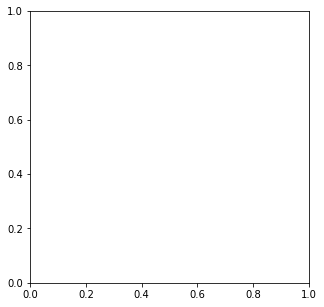

In [57]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.countplot(
    data=df_flat,
    y=COL_TRANSF,
    hue='generated_a_crash',
    ax=ax
)
ax.set_xlabel("No. program pairs containing the transformation")
ax.set_ylabel("Metamorphic transformation")
ax.legend(title="Lead to crash")

## Which is the average number of other (different) transformation families applied with each transformation family?

In [60]:
ALL_TRANSFORMATIONS = list(df_flat[COL_TRANSF].unique())

n_other_transf = []

for transf in ALL_TRANSFORMATIONS:
    program_ids_w_transf = df_flat[df_flat[COL_TRANSF] == transf]["program_id"]
    df_program_w_this_transf = df[df["program_id"].isin(program_ids_w_transf)]
    df_program_w_this_transf["n_transf"] = df_program_w_this_transf[COL_TRANSF].apply(
        lambda e: len(e)
    )
    avg_n_other_transf = float(df_program_w_this_transf["n_transf"].mean())
    n_other_transf.append(avg_n_other_transf)

/tmp/ipykernel_21158/4145143245.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_program_w_this_transf["n_transf"] = df_program_w_this_transf[COL_TRANSF].apply(


<BarContainer object of 10 artists>

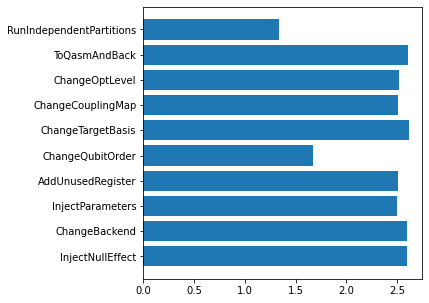

In [66]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.barh(
    y=ALL_TRANSFORMATIONS,
    width=n_other_transf    
)

## To real bugs (unique root causes)

# RQ4: which is the most time expensive step in QMFuzz?

In [38]:
# IDEA: measure the time of each step and create a barchart with percentage and one with absolute values

In [15]:
relevant_time_cols = [
    'program_id',
    'time_exec',
    'source.time_generation',
    #'followup.time_generation', # this attribute is statically copied form source
    'followup.time_metamorph',
    'divergence.ks.time',
    'generated_a_crash'
]

df_time = df_generated_programs[relevant_time_cols]
df_time.head()

,program_id,time_exec,source.time_generation,followup.time_metamorph,divergence.ks.time,generated_a_crash
0,09b76b74e7fa4bed9b8e153e2b8c228b,0.520480,0.006663,0.029449,0.000857,False
1,d733d94d007e42498ed2d7504669aa87,0.529619,0.004189,0.018908,0.007440,False
2,844ff4a7fa4143d38dabe28d1454cc3a,0.466335,0.006113,0.007506,0.005073,False
3,fef380c735f5417f8f329f27e4733234,0.451260,0.006208,0.025475,0.001749,False
4,e031814553554c81a625588c2fc05159,1.865207,0.005532,0.023781,0.006965,False


In [16]:
df_time_melt = pd.melt(
    df_time, id_vars=['program_id', 'generated_a_crash'], 
    value_vars=relevant_time_cols.remove('program_id'))
df_time_melt.head(20)

,program_id,generated_a_crash,variable,value
0,09b76b74e7fa4bed9b8e153e2b8c228b,False,time_exec,0.520480
1,d733d94d007e42498ed2d7504669aa87,False,time_exec,0.529619
2,844ff4a7fa4143d38dabe28d1454cc3a,False,time_exec,0.466335
3,fef380c735f5417f8f329f27e4733234,False,time_exec,0.451260
4,e031814553554c81a625588c2fc05159,False,time_exec,1.865207
5,ced8ce74368e4bc98d49d4eb1781b09c,False,time_exec,0.822178
6,cbe7b0a3724045e3bad2f92e700d78c7,False,time_exec,0.750860
7,994871e3bf744cdfac6e036808e0b724,False,time_exec,0.594772
8,912c45960a5a49dab0163dcb21ddcf9d,False,time_exec,0.311148
9,5b3a12f45b5445b4b265c239f079200c,False,time_exec,0.504680


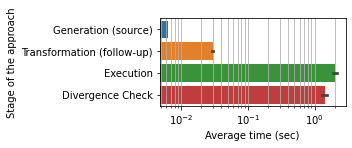

In [18]:
fig, ax = plt.subplots(figsize=(5, 2))

mapping = {
    "source.time_generation": 'Generation (source)',
    "followup.time_metamorph": 'Transformation (follow-up)',
    "time_exec": "Execution",
    "divergence.ks.time": "Divergence Check"
}

sns.barplot(
    data=df_time_melt,
    y='variable',
    x='value',
    order=list(mapping.keys()),
    ax=ax
)

original_labels = ax.get_yticklabels()
ax.set_yticklabels(labels=[
    mapping.get(e._text, e._text)
    for e in original_labels
])
ax.grid(axis='x', which='both')
ax.set_xscale('log')
ax.set_ylabel('Stage of the approach')
ax.set_xlabel('Average time (sec)')

plt.tight_layout()
fig.savefig(os.path.join(OUT_FOLDER, "RQ4_time_analysis.pdf"))

# RQ4: how many bugs are detected via a divergence as opposed to those detected because of a crash?

# Sample some warinings for manual inspection
Pick those which are raised by STATIC THRESHOLD but not by HOLM & CO

In [87]:
program_ids_static = get_alarms_with_method(
    df=df_data, 
    pval_col=PVAL_COL,
    alpha_level=ALPHA_LEVEL,
    method='static')
program_ids_bonferroni = get_alarms_with_method(
    df=df_data, 
    pval_col=PVAL_COL,
    alpha_level=ALPHA_LEVEL,
    method='bonferroni')

In [88]:
program_ids_bonferroni

['facbe4f34bd540d78f311cd76099dfab']

In [32]:
program_ids_static

['a72f970553aa40f7b7a57f5b111dc5df',
 '29d5e306618a471f8d1b5cd95918d2c4',
 '3fa7d36aeb2b4cfe890102b05fe368f5',
 'b4759f36f35f47b392bcff56acce6023',
 'ccfdc77316714af19593fe1a47c8a934',
 '1e73180ce8fb43159f102238e237a223',
 '2bd88c1df0264570ab0937a2a6ca8399',
 '296ceddbffc1450a818ed5fe7945d35e',
 'c0accb860e8b4f2ca58a6eb6b6e37139',
 '440b81571ab54e87afbc28dc3ad4371f',
 '3398ea9361034afea8ef582c85685c94',
 'acc1bf6f904b4829b085dce0635dabd6',
 '1a59a301e2d04b40b1042341bb9bdd91',
 '578b8a5dbf9a4667a0a2521e1353359e',
 '2e7c2605987c432cbfed7721fe9d6087',
 '53fc786902a24f389f2a92246ba6028d',
 '84c729d4b94043889de65f5cca28fe2e',
 '238241eede514c338dc31d6407b7a7f5',
 'f997c24e2ef2475c86b39b426f068ba9',
 '9cd21236a4aa4806ad98c71f1d9f223d',
 '3b0bdc986a6347a2a31bbc7e417facdc',
 '3673b1768ed7410ba10f20fa7ee01af5',
 'c5bc7c63e9694b1ca66656ef2ecdf594',
 'cc5df128c70e44438e8ae36c34f4e9a9',
 'ed3ee448077d4b5b9d2791d0a0878d33',
 '45642086e9b447ea9f194438bf22a49f',
 '679f53e94a624525800a0c9285decab4',
 

In [35]:
static_and_not_bonferroni = np.array(list(set(program_ids_static).difference(set(program_ids_bonferroni))))
SAMPLE_SIZE = 20
to_inspect = list(np.random.choice(static_and_not_bonferroni, size=SAMPLE_SIZE, replace=False))
print(EXP_FOLDER)
to_inspect

qmt_v08


['e24794609b514601a89331bf29ef1819',
 '1c2c5a0e4e3c4c3f9a818196a20ae4df',
 '3676a2c3740c441c82a542d020f0c655',
 'd6a933073c08475c8cb5d086159507aa',
 '73ccbfd3e22a4c3f96e53877538131b9',
 'f20d705228d74bd7815d6aac5d5ffa4d',
 '1be0b5b537fd45dd97f57a21568d8b5c',
 '153264c42d0c43c3b60cbc9f0314bbda',
 '3af48e21139c4580b98b3a2377363ce6',
 'd5db890201a44910b5e4a878f6dba3d5',
 '1fab3be056384615a7e734fc8e7bffb5',
 '334a5da11f544a55bafc5e6e094d0e42',
 'f56101e316bd48b6ac975faef5feea8d',
 '534542b3c27b4ce0a0f6e0136473c860',
 'd94b3b30470545c88fb0b651c2409a62',
 '8f6665957fae4e4c9b423267b17356bc',
 'db61c051d5834a24926c92881ab9b787',
 'e001a2d718814953986e524b0772782a',
 '83d773edd030460f822a111e2bb251fa',
 'b52e90b7f78b4b609ed710496783bcf4']

# Miscellanea

## RQ-A: how many syntactically different programs?
can be generated by QMFuzz in a fixed time (2 days, as used by QDiff [31] for the execution)?

In [5]:
# IDEA: we could cluster them in different groups (e.g. single circuit, two circuits, etc...)
# IDEA: we could check which gates were used by each group 
# (i.e. plot the statistic about the use of a certain type of gate)
# plot the stats on the length of the sequence of operations, n.qubits

In [16]:
relevant_columns = [c for c in df_data.columns if c.startswith("source.")]
df_generated_programs = pd.concat(
    [
        df_data[relevant_columns].assign(crash_dataset=False),
        df_crash[relevant_columns].assign(crash_dataset=True)
    ],
    axis=0
)
df_generated_programs.reset_index(drop=True, inplace=True)
df_generated_programs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9535 entries, 0 to 9534
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   source.program_id             9535 non-null   object 
 1   source.selected_gate_set      9535 non-null   object 
 2   source.selected_optimization  9535 non-null   object 
 3   source.shots                  9535 non-null   int64  
 4   source.n_qubits               9535 non-null   int64  
 5   source.n_ops                  9535 non-null   int64  
 6   source.opt_level              9535 non-null   int64  
 7   source.target_gates           0 non-null      object 
 8   source.py_file_path           9535 non-null   object 
 9   source.time_generation        9535 non-null   float64
 10  source.circuit_id             9535 non-null   object 
 11  source.id_quantum_reg         9535 non-null   object 
 12  source.id_classical_reg       9535 non-null   object 
 13  sou

In [143]:
def plot_numeric_attirbute(df, attribute, x_label=None, title=None, **pltargs):
    """Show the distplot of the given attribute."""
    ax = sns.histplot(
        data=df,
        x=attribute,
        bins=np.arange(0.5, df_generated_programs[attribute].max() + 1),
        **pltargs
    )
    if x_label:
        ax.set_xlabel(x_label)
    if title:
        ax.set_title(title)

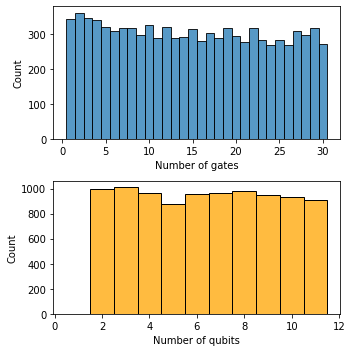

In [148]:
fig, axes = plt.subplots(2, 1, figsize=(5,5))

ax_gates, ax_qubits = axes
plot_numeric_attirbute(
    df=df_generated_programs, 
    attribute='source.n_ops', 
    x_label="Number of gates",
    ax=ax_gates)
plot_numeric_attirbute(
    df=df_generated_programs, 
    attribute='source.n_qubits', 
    x_label="Number of qubits",
    color='orange',
    ax=ax_qubits)
plt.tight_layout()

fig.savefig(os.path.join(OUT_FOLDER, "RQ1_distribution_n_gates_n_qubits.pdf"))

## RQ-B: how effective is the varying-threshold approach in reducing the number of false positives?

<AxesSubplot:xlabel='divergence.ks.p-value', ylabel='Count'>

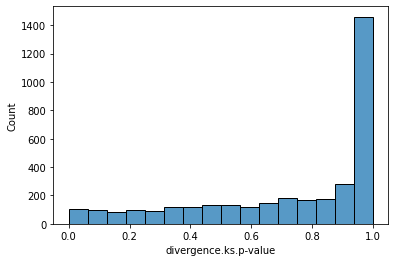

In [80]:
sns.histplot(
    data=df_data,
    x='divergence.ks.p-value'
)

In [81]:
static_treshold = 0.05

threshold_col = "divergence.ks.p-value"
df_programs_w_static_threshold = df_data[
    df_data[threshold_col] <= static_treshold
]
n_alarms_w_static_threshold = len(df_programs_w_static_threshold)
print(f"STATIC THRESHOLD APPROACH produces {n_alarms_w_static_threshold} alarms.")

STATIC THRESHOLD APPROACH produces 85 alarms.


In [82]:
method = 'holm'
pval_col = threshold_col
alpha_level = static_treshold

def get_alarms_with_method(df, pval_col, alpha_level, method):
    """Get the program ids of the warnings raised by a method."""
    df_sorted_pvals = df.sort_values(by=[pval_col])
    k = len(df_sorted_pvals)
    i_star = None
    program_ids = []
    for i, (idx, row) in enumerate(df_sorted_pvals.iterrows()):
        ordinal_i = i + 1
        program_ids.append(row["program_id"])
        P_i = row[pval_col]
        if method == 'holm':
            threshold = alpha_level / (k - ordinal_i + 1)
        elif method == 'bonferroni':
            threshold = alpha_level / (k)
        elif method == 'bh':
            threshold = (alpha_level / (k)) * ordinal_i
        # print(f"(i: {ordinal_i}) current p-value: {P_i} vs threshold: {threshold}")
        elif method == 'static':
            threshold = alpha_level        
        if P_i > threshold:
            i_star = i
            #print(f"i*: {i_star}")
            break
    return program_ids


def count_alarm_with_method(df, pval_col, alpha_level, method):
    """Count the number of warnings raised by a method."""
    return len(get_alarms_with_method(
        df=df,
        pval_col=pval_col,
        alpha_level=alpha_level,
        method=method        
    ))  


def get_first_n(df, col_time, n=1000):
    """Get the first n records as ordered by the time column."""
    return df.sort_values(by=col_time).iloc[:n]

#n_alarms_w_varying_threshold = i_star
#print(f"VARYING THRESHOLD APPROACH produces {n_alarms_w_varying_threshold} alarms.")

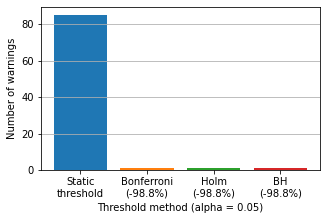

In [83]:
fig, ax = plt.subplots(figsize=(5, 3))

mapping = {
    "bonferroni": 'Bonferroni',
    "holm": 'Holm',
    "bh": "BH"
}

methods_to_try = ['bonferroni', 'holm', 'bh']
n_alarms_w_methods = [
    count_alarm_with_method(
        df=df_data, 
        pval_col=threshold_col,
        alpha_level=static_treshold,
        method=m) for m in methods_to_try]


n_alarms = [n_alarms_w_static_threshold] + n_alarms_w_methods
bars = ['Static\nthreshold'] + list(map(mapping.get, methods_to_try))
y_pos = np.arange(len(bars))

reductions = [
    ((n_alarms_w_static_threshold - abs_val) / n_alarms_w_static_threshold) * 100
    for abs_val in n_alarms
]
bars = [l + f"\n(-{red:.1f}%)" if red > 0 else l
        for l, red in zip(bars, reductions)]

ax.bar(y_pos, n_alarms, color=sns.color_palette()[:len(bars)])
ax.grid(axis='y')
ax.set_ylabel("Number of warnings")
ax.set_xlabel(f"Threshold method (alpha = {static_treshold})")
plt.xticks(y_pos, bars)
plt.show()
fig.savefig(os.path.join(OUT_FOLDER, "RQ3_n_alarms_per_threshold_approach.pdf"))

## RQ-B.2 compute the reduction as a function of n pairs

In [84]:
df_data.shape

(3495, 42)

In [85]:
mapping = {
    "bonferroni": 'Bonferroni',
    "holm": 'Holm',
    "bh": "BH",
    "static": "Static Threshold"
}

tot_n_records = len(df_data)
print(f"The dataset has {tot_n_records} records in total.")

methods_to_try = mapping.keys()

records = []
for n in tqdm(np.arange(100, tot_n_records, 100)):
    new_record = {"n": n}
    for method in methods_to_try:
        c_method_n_warinings = count_alarm_with_method(
            df=get_first_n(
                df=df_data, col_time="abs_start_time", n=n), 
            pval_col=PVAL_COL,
            alpha_level=ALPHA_LEVEL,
            method=method)
        new_record[method] = c_method_n_warinings
    records.append(new_record)
    
df_warnings_w_n = pd.DataFrame.from_records(records)
df_warnings_w_n = df_warnings_w_n.rename(columns=mapping)
df_warnings_w_n = pd.melt(
    df_warnings_w_n, 
    id_vars=['n'], 
    value_vars=[v for k, v in mapping.items()])
df_warnings_w_n.head()


The dataset has 3495 records in total.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 41.60it/s]


,n,variable,value
0,100,Bonferroni,1
1,200,Bonferroni,1
2,300,Bonferroni,1
3,400,Bonferroni,1
4,500,Bonferroni,1


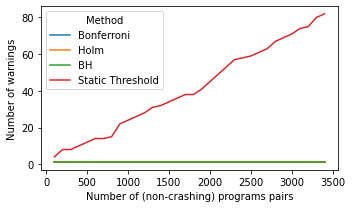

In [86]:
fig, ax = plt.subplots(figsize=(5, 3))

sns.lineplot(
    data=df_warnings_w_n.rename(columns={
        'variable': 'Method'
    }),
    x='n',
    y='value',
    hue="Method",
    ax=ax
)
ax.set_ylabel('Number of warnings')
ax.set_xlabel('Number of (non-crashing) programs pairs')
plt.tight_layout()
#fig.savefig(os.path.join(OUT_FOLDER, "RQ3_n_warning_as_function_of_n.pdf"))